# CNN for boats classification

In [1]:
# Import libraries
import cv2
import matplotlib.pyplot as plt
import numpy as np
import glob
import pandas as pd
import random as rd
import os

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
np.random.seed(11)
rd.seed(11)

## Utils function

In [2]:
def iou(boxA, boxB):
    """
    Compute the IOU metric
    -----------------
    Parameters:
        boxA, boxB are list of corners, top left corner and bottom right corner
        in total 4 coordinates for box [x_tl, y_tl, x_br, y_br]
    Cite:
        https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/
    """
    # computation of top left and bottom right coordinates
    # for the interseption rectangle
    xi_1 = max(boxA[0], boxB[0])
    yi_1 = max(boxA[1], boxB[1])
    xi_2 = min(boxA[2], boxB[2])
    yi_2 = min(boxA[3], boxB[3])
    
    
    # interseption area
    area_i = max(0, xi_2 - xi_1 + 1) * max(0, yi_2 - yi_1 + 1)
    
    # areas box A and box B
    area_A = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    area_B = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    
    # Interseption over Union
    iou = area_i / float(area_A + area_B - area_i)
    return iou

In [3]:
def extract_name(absolute_path):
    i = 0
    for j in range(len(absolute_path)):
        char = absolute_path[j]
        if char == '/' or char == '\\':
            i = j
    name = absolute_path[i+1:-4]
    return name

In [4]:
def patch(img, box, resize=True):
    """
    It returns the corresponding patch given a bounding box and an image
    box has structure [xa, ya, xb, yb]
    (xa, ya) top left corner
    (xb, yb) bottom right corner
    """
    xa = box[0]
    ya = box[1]
    xb = box[2]
    yb = box[3]
    
    result = img[ya:yb, xa:xb]
    
    if resize:
        result = cv2.resize(result, (224,224), interpolation = cv2.INTER_LINEAR)
    return result

## Loading true bounding boxes and images

The initial dataset is downloadable from this link: https://drive.google.com/file/d/1XkVfXNjq_KMANKUBSlbpPrlMNe9cMhKk/view?usp=sharing  
Note: This is a jupyter notebook for the course of Computer Vision a.a. 2020-21 of the University of Padua, therefore to access the user must have a university account @studenti.unipd.it

Loading ground truth bounding boxes as pandas dataframes

In [5]:
gt_boxes = []
folder = "../dataset/FINAL_DATASET/TRAINING_DATASET/LABELS_TXT"
folder +=  "/*.txt"

filenames = []

for path in glob.glob(folder):
    file = extract_name(path)
    
    # We use a pandas dataframe for each image to store all bounding boxes
    if os.path.getsize(path) > 0:
        filenames.append(file)
        df = pd.read_csv(path, sep=';', header=None).iloc[:,:-1]
        series = df.iloc[:,0]
        new_column = []
        for elem in series:
            elem = elem.split(':')
            new_column.append(int(elem[-1]))
        df.iloc[:,0] = new_column

        gt_boxes.append(df)
    
print("Number of boats with labels: {}".format(len(gt_boxes)))

Number of boats with labels: 3106


Example of bounding boxes given an image:

In [6]:
gt_boxes[0]

,0,1,2,3
0,304,598,44,132
1,436,562,2,30


Loading images

In [7]:
folder = "../dataset/FINAL_DATASET/TRAINING_DATASET/IMAGES"
X_boats = []

for name in filenames:
    file = folder + "/" + name + ".png"
    X_boats.append(cv2.cvtColor(cv2.imread(file), cv2.COLOR_BGR2RGB))
    
print("Number of boats loaded: {}".format(len(X_boats)))

Number of boats loaded: 3106


## ML Dataset creation

In order to have an acceptable number of samples for training, the following steps are used:
1. All ground truth box are considered, these regions are cropped and resized such that to be a feasible input for a CNN;
2. To increase the number of positive samples (boats, class 1) we add also other combinations of boxes for which the metric IoU (Interseption over Union) is >= 0.9, a possible maximum of 10 additional samples are generated for each ground truth box;
3. All members of class 0 (no-boats) are random boxes such that their IoU is equal to zero. The aim is to have samples representative of the background.

Class 1: boats

In [8]:
# Resizing all images
# Bilinear interpolation
image_size = (224,224)
X = []

for i in range(len(X_boats)):
    img = X_boats[i]
    for j in range(gt_boxes[i].shape[0]):
        true_box = gt_boxes[i].iloc[j,:].to_list()
        X.append(patch(img, [true_box[0], true_box[2], true_box[1], true_box[3]]))

In [9]:
Y = [1 for elem in X]

In [10]:
MAX_POSITIVES = 10

count = 0
for n in range(MAX_POSITIVES):
    for i in range(len(X_boats)):
        img = X_boats[i]
        for j in range(gt_boxes[i].shape[0]):
            true_box = gt_boxes[i].iloc[j,:].to_list()

            x = rd.randint(-20, 20)
            y = rd.randint(-20, 20)
            
            # New coordinates
            c1 = true_box[0] + x
            c2 = true_box[2] + y
            c3 = true_box[1] + x
            c4 = true_box[3] + y
            
            # Checking not be out of boundaries
            # x-axis
            if c1 < 0: c1 = 0
            if c1 > img.shape[1]: c1 = img.shape[1]
            if c3 < 0: c3 = 0
            if c3 > img.shape[1]: c3 = img.shape[1]
            # y-axis
            if c2 < 0: c2 = 0
            if c2 > img.shape[0]: c2 = img.shape[0]
            if c4 < 0: c4 = 0
            if c4 > img.shape[0]: c4 = img.shape[0]

            box = [c1, c2, c3, c4]

            # If the bounding box chosen randomly must have a IoU >= 0.9
            # with any true bounding box, than we consider this a true image
            # Class 1 of boats
            check = True
            for j in range(gt_boxes[i].shape[0]):
                true_box = gt_boxes[i].iloc[j,:].to_list()
                if iou(box, [true_box[0], true_box[2], true_box[1], true_box[3]]) < 0.9: 
                    check = False
            if check:
                X.append(patch(img, box))
                Y.append(1)
                count += 1

In [11]:
print("Number of class 1 samples: {}".format(len(X)))
print("Number of labels: {}".format(len(Y)))

Number of class 1 samples: 10777
Number of labels: 10777


Class 0: others

In [12]:
MAX_NEGATIVES = 15

count = 0
for n in range(MAX_NEGATIVES):
    for i in range(len(X_boats)):
        img = X_boats[i]
        x = rd.randint(0, img.shape[1] - image_size[0])
        y = rd.randint(0, img.shape[0] - image_size[1])

        box = [x, y, x + image_size[0], y + image_size[1]]

        # If the bounding box chosen randomly must have a IoU = 0
        # with any true bounding box, than we consider this a false image
        # Class 0 of no-boats
        check = True
        for j in range(gt_boxes[i].shape[0]):
            true_box = gt_boxes[i].iloc[j,:].to_list()
            if iou(box, [true_box[0], true_box[2], true_box[1], true_box[3]]) > 0: 
                check = False
        if check:
            X.append(patch(img, box, False))
            Y.append(0)
            count += 1

In [13]:
print("Number of class 0 samples: {}".format(count))
print()
print("Number of TOTAL samples: {}".format(len(X)))
print("Number of labels: {}".format(len(Y)))

Number of class 0 samples: 12641

Number of TOTAL samples: 23418
Number of labels: 23418


Convert everything into numpy array objects and split X and Y in training set, validation set and test set.

In [14]:
X = np.array(X)
print("X:")
print(X.shape)
print()
print("Number of samples: {}".format(X.shape[0]))
print("Image shape: ({},{})".format(X.shape[1], X.shape[2]))
print("Number of channels: {}".format(X.shape[3]))

Y = np.array(Y)
print()
print("Y:")
print(Y.shape)

X:
(23418, 224, 224, 3)

Number of samples: 23418
Image shape: (224,224)
Number of channels: 3

Y:
(23418,)


In [15]:
# Now we split the dataset into
# 1. training set
# 2. validation set
# 3. test set

X_train_val, X_test, y_train_val, y_test = train_test_split(X, Y, test_size=0.33, shuffle=True, random_state=11)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, shuffle=True, random_state=11)
print("Training set: {} and {}".format(X_train.shape, y_train.shape))
print("Validation set: {} and {}".format(X_val.shape, y_val.shape))
print("Test set: {} and {}".format(X_test.shape, y_test.shape))

Training set: (12552, 224, 224, 3) and (12552,)
Validation set: (3138, 224, 224, 3) and (3138,)
Test set: (7728, 224, 224, 3) and (7728,)


To save memory space, the variables that are not needed anymore are deallocated.

In [16]:
import gc
del X
del Y
gc.collect()

120

Plot some samples:

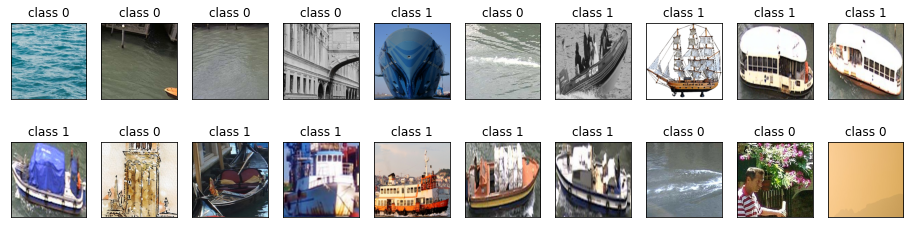

In [17]:
rows = 2
cols = 10
count = 0
fig, ax = plt.subplots(rows, cols, figsize=(16,4))

for i in range(rows):
    for j in range(cols):
        ax[i,j].imshow(X_train[count,:,:,:])
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])
        ax[i,j].set_title('class ' + str(y_train[count]))
        count += 1
plt.savefig('../report/figures/dataset_samples.png')

**Input normalization** (optional)  
The mean and standard deviation are computed only for the training set, then these values are used to normalize images also for the validation and test set. Note: the computation on the whole training set requires too much memory, therefore the usage of a random batch of 512 training samples.

In [18]:
NORMALIZATION = False

if NORMALIZATION:
    batch_indices = rd.choices(list(range(X_train.shape[0])), k=512)

    # A computation for each channel
    mean_features1 = np.mean(X_train[batch_indices,:,:,0], axis=0)
    mean_features2 = np.mean(X_train[batch_indices,:,:,1], axis=0)
    mean_features3 = np.mean(X_train[batch_indices,:,:,2], axis=0)
    std_features1 = np.std(X_train[batch_indices,:,:,0], axis=0)
    std_features2 = np.std(X_train[batch_indices,:,:,1], axis=0)
    std_features3 = np.std(X_train[batch_indices,:,:,2], axis=0)

    mean_features = [mean_features1, mean_features2, mean_features3]
    std_features = [std_features1, std_features2, std_features3]

    for i in range(3):
        X_train[:,:,:,i] = (X_train[:,:,:,i] - mean_features[i]) / std_features[i]
        X_val[:,:,:,i] = (X_val[:,:,:,i] - mean_features[i]) / std_features[i]  
        X_test[:,:,:,i] = (X_test[:,:,:,i] - mean_features[i]) / std_features[i]
        
    # Saving matrices
    np.savetxt("mean_features1.txt", mean_features1)
    np.savetxt("mean_features2.txt", mean_features2)
    np.savetxt("mean_features3.txt", mean_features3)
    
    np.savetxt("std_features1.txt", std_features1)
    np.savetxt("std_features2.txt", std_features2)
    np.savetxt("std_features3.txt", std_features3)

## CLASSIFICATION

## Shallow model

In [19]:
shallow_model = models.Sequential()
shallow_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=X_train.shape[1:], padding='same'))
shallow_model.add(layers.MaxPooling2D((2, 2)))

shallow_model.add(layers.Flatten())
shallow_model.add(layers.Dense(1, activation='sigmoid'))

shallow_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
flatten (Flatten)            (None, 401408)            0         
_________________________________________________________________
dense (Dense)                (None, 1)                 401409    
Total params: 402,305
Trainable params: 402,305
Non-trainable params: 0
_________________________________________________________________


In [20]:
shallow_model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [21]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history1 = shallow_model.fit(X_train, y_train, epochs=10, batch_size=128, validation_data=(X_val, y_val), callbacks=[callback])

Epoch 1/10
99/99 [==============================] - 167s 2s/step - loss: 148.4490 - accuracy: 0.7062 - val_loss: 2.8852 - val_accuracy: 0.8231
Epoch 2/10
99/99 [==============================] - 157s 2s/step - loss: 1.4820 - accuracy: 0.8666 - val_loss: 1.3530 - val_accuracy: 0.8652
Epoch 3/10
99/99 [==============================] - 159s 2s/step - loss: 0.5195 - accuracy: 0.9185 - val_loss: 1.1242 - val_accuracy: 0.8853
Epoch 4/10
99/99 [==============================] - 156s 2s/step - loss: 0.2287 - accuracy: 0.9449 - val_loss: 0.9040 - val_accuracy: 0.8821
Epoch 5/10
99/99 [==============================] - 153s 2s/step - loss: 0.1717 - accuracy: 0.9529 - val_loss: 0.9942 - val_accuracy: 0.8866
Epoch 6/10
99/99 [==============================] - 155s 2s/step - loss: 0.1236 - accuracy: 0.9662 - val_loss: 0.9240 - val_accuracy: 0.8926
Epoch 7/10
99/99 [==============================] - 153s 2s/step - loss: 0.1144 - accuracy: 0.9685 - val_loss: 0.9117 - val_accuracy: 0.8920


In [22]:
scores = shallow_model.evaluate(X_test, y_test, verbose=2)
print("Test %s: %.2f%%" % (shallow_model.metrics_names[1], scores[1]*100))

242/242 - 32s - loss: 1.0368 - accuracy: 0.8780
Test accuracy: 87.80%


## Deep model 1

In [23]:
deep_model1 = models.Sequential()
deep_model1.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=X_train.shape[1:], padding='same'))
deep_model1.add(layers.MaxPooling2D((2, 2)))

deep_model1.add(layers.Flatten())
deep_model1.add(layers.Dense(128, activation='relu'))
deep_model1.add(layers.Dense(64, activation='relu'))
deep_model1.add(layers.Dense(32, activation='relu'))
deep_model1.add(layers.Dense(1, activation='sigmoid'))

deep_model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 401408)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               51380352  
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                

In [24]:
deep_model1.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [25]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history2 = deep_model1.fit(X_train, y_train, epochs=10, batch_size=128, validation_data=(X_val, y_val), callbacks=[callback])

Epoch 1/10
99/99 [==============================] - 195s 2s/step - loss: 285.7466 - accuracy: 0.7260 - val_loss: 6.0104 - val_accuracy: 0.8190
Epoch 2/10
99/99 [==============================] - 191s 2s/step - loss: 1.8698 - accuracy: 0.8846 - val_loss: 1.7691 - val_accuracy: 0.8639
Epoch 3/10
99/99 [==============================] - 187s 2s/step - loss: 0.5171 - accuracy: 0.9310 - val_loss: 1.1626 - val_accuracy: 0.9041
Epoch 4/10
99/99 [==============================] - 189s 2s/step - loss: 0.3527 - accuracy: 0.9440 - val_loss: 2.1140 - val_accuracy: 0.7467
Epoch 5/10
99/99 [==============================] - 189s 2s/step - loss: 0.2693 - accuracy: 0.9504 - val_loss: 1.0465 - val_accuracy: 0.8744
Epoch 6/10
99/99 [==============================] - 189s 2s/step - loss: 0.1758 - accuracy: 0.9636 - val_loss: 1.8588 - val_accuracy: 0.8964
Epoch 7/10
99/99 [==============================] - 187s 2s/step - loss: 0.2405 - accuracy: 0.9588 - val_loss: 1.2331 - val_accuracy: 0.9076
Epoch 8/10


In [26]:
scores = deep_model1.evaluate(X_test, y_test, verbose=2)
print("Test %s: %.2f%%" % (deep_model1.metrics_names[1], scores[1]*100))

242/242 - 39s - loss: 1.1949 - accuracy: 0.8483
Test accuracy: 84.83%


## Deep model 2

In [27]:
deep_model2 = models.Sequential()
deep_model2.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=X_train.shape[1:], padding='same'))
deep_model2.add(layers.MaxPooling2D((2, 2)))
deep_model2.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same'))
deep_model2.add(layers.MaxPooling2D((2, 2)))
deep_model2.add(layers.Conv2D(4, (3, 3), activation='relu',  padding='same'))
deep_model2.add(layers.MaxPooling2D((2, 2)))

deep_model2.add(layers.Flatten())
deep_model2.add(layers.Dense(128, activation='relu'))
deep_model2.add(layers.Dense(64, activation='relu'))
deep_model2.add(layers.Dense(32, activation='relu'))
deep_model2.add(layers.Dense(1, activation='sigmoid'))

deep_model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 16)      4624      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 56, 56, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 56, 56, 4)         580       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 28, 28, 4)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 3136)             

In [28]:
deep_model2.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [29]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history3 = deep_model2.fit(X_train, y_train, epochs=10, batch_size=128, validation_data=(X_val, y_val), callbacks=[callback])

Epoch 1/10
99/99 [==============================] - 274s 3s/step - loss: 1.8109 - accuracy: 0.7686 - val_loss: 0.2996 - val_accuracy: 0.8728
Epoch 2/10
99/99 [==============================] - 270s 3s/step - loss: 0.3072 - accuracy: 0.8771 - val_loss: 0.2620 - val_accuracy: 0.8907
Epoch 3/10
99/99 [==============================] - 262s 3s/step - loss: 0.1971 - accuracy: 0.9255 - val_loss: 0.2050 - val_accuracy: 0.9226
Epoch 4/10
99/99 [==============================] - 259s 3s/step - loss: 0.1506 - accuracy: 0.9424 - val_loss: 0.3380 - val_accuracy: 0.8764
Epoch 5/10
99/99 [==============================] - 259s 3s/step - loss: 0.1251 - accuracy: 0.9549 - val_loss: 0.1907 - val_accuracy: 0.9321
Epoch 6/10
99/99 [==============================] - 257s 3s/step - loss: 0.1147 - accuracy: 0.9612 - val_loss: 0.1730 - val_accuracy: 0.9382
Epoch 7/10
99/99 [==============================] - 259s 3s/step - loss: 0.0700 - accuracy: 0.9764 - val_loss: 0.1608 - val_accuracy: 0.9436
Epoch 8/10
99

In [30]:
scores = deep_model2.evaluate(X_test, y_test, verbose=2)
print("Test %s: %.2f%%" % (deep_model2.metrics_names[1], scores[1]*100))

242/242 - 42s - loss: 0.2179 - accuracy: 0.9312
Test accuracy: 93.12%


## Analysis

Plots

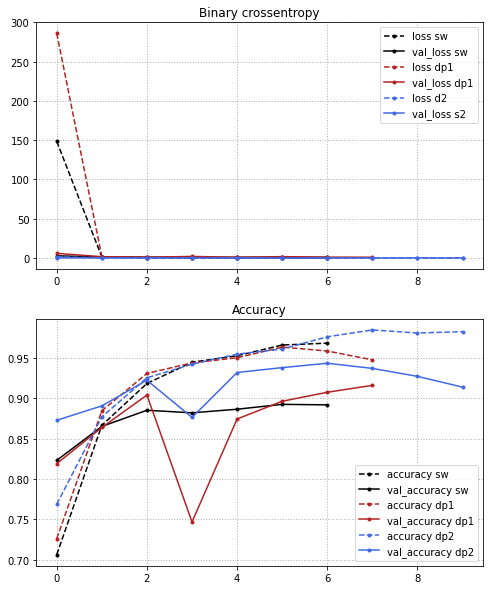

In [31]:
fig, ax = plt.subplots(2,1, figsize=(8,10))

color1 = 'k'
color2 = 'firebrick'
color3 = 'royalblue'

# ------------ shallow model
ax[0].plot(history1.epoch,history1.history['loss'], label="loss sw", color=color1, marker='.', linestyle='--')
ax[0].plot(history1.epoch,history1.history['val_loss'], label="val_loss sw", color=color1, marker='.', linestyle='-')
# ------------ transfer learning model
ax[0].plot(history2.epoch,history2.history['loss'], label="loss dp1", color=color2, marker='.', linestyle='--')
ax[0].plot(history2.epoch,history2.history['val_loss'], label="val_loss dp1", color=color2, marker='.', linestyle='-')
# ------------ transfer learning model 2
ax[0].plot(history3.epoch,history3.history['loss'], label="loss d2", color=color3, marker='.', linestyle='--')
ax[0].plot(history3.epoch,history3.history['val_loss'], label="val_loss s2", color=color3, marker='.', linestyle='-')
ax[0].legend()
ax[0].title.set_text('Binary crossentropy')
ax[0].grid(linestyle=':', linewidth=1)

# ------------ shallow model
ax[1].plot(history1.epoch,history1.history['accuracy'], label="accuracy sw", color=color1, marker='.', linestyle='--')
ax[1].plot(history1.epoch,history1.history['val_accuracy'], label="val_accuracy sw", color=color1, marker='.', linestyle='-')
# ------------ transfer learning model
ax[1].plot(history2.epoch,history2.history['accuracy'], label="accuracy dp1", color=color2, marker='.', linestyle='--')
ax[1].plot(history2.epoch,history2.history['val_accuracy'], label="val_accuracy dp1", color=color2, marker='.', linestyle='-')
# ------------ transfer learning model 2
ax[1].plot(history3.epoch,history3.history['accuracy'], label="accuracy dp2", color=color3, marker='.', linestyle='--')
ax[1].plot(history3.epoch,history3.history['val_accuracy'], label="val_accuracy dp2", color=color3, marker='.', linestyle='-')
ax[1].legend()
ax[1].title.set_text('Accuracy')
ax[1].grid(linestyle=':', linewidth=1)

plt.savefig('../report/figures/loss_acc.png')

plt.show()

In [32]:
from sklearn.metrics import roc_curve
y_pred = shallow_model.predict(X_test)
fpr1, tpr1, th1 = roc_curve(y_test, y_pred)

y_pred = deep_model1.predict(X_test)
fpr2, tpr2, th2 = roc_curve(y_test, y_pred)

y_pred = deep_model2.predict(X_test)
fpr3, tpr3, th3 = roc_curve(y_test, y_pred)

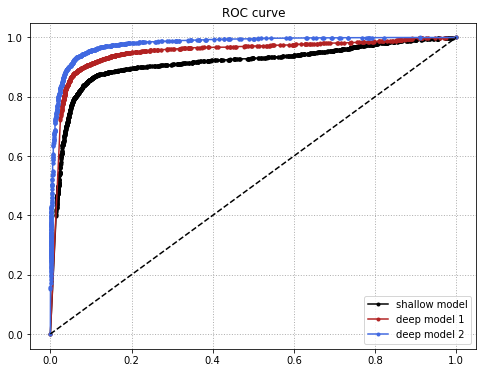

In [33]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(fpr1, tpr1, label="shallow model", color=color1, marker='.', linestyle='-')
ax.plot(fpr2, tpr2, label="deep model 1", color=color2, marker='.', linestyle='-')
ax.plot(fpr3, tpr3, label="deep model 2", color=color3, marker='.', linestyle='-')
ax.plot([0, 1], [0, 1], color='k', linestyle='--')
ax.legend()
ax.title.set_text('ROC curve')
ax.grid(linestyle=':', linewidth=1)

plt.savefig('../report/figures/roc_curve.png')

plt.show()

Looking at the roc curve and also observing the test set accuracy results is possible to say that _deep model 2_ is the best one, among the CNNs considered so far. Therefore _deep model 2_ is the model which will be used in the c++ application for boats detection.

## From Tensorflow to OpenCV

In [34]:
deep_model2.save('my_model', save_format='tf')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: my_model\assets


In [35]:
loaded = tf.saved_model.load('my_model')
infer = loaded.signatures['serving_default']

f = tf.function(infer).get_concrete_function(tf.TensorSpec(shape=[None, 224, 224, 3], dtype=tf.float32))
f2 = convert_variables_to_constants_v2(f)
graph_def = f2.graph.as_graph_def()

# Export frozen graph
with tf.io.gfile.GFile('frozen_graph.pb', 'wb') as f:
    f.write(graph_def.SerializeToString())

Test to see if the tensorflow model can be loaded correctly into OpenCV:

In [36]:
net = cv2.dnn.readNet('frozen_graph.pb')
inp = np.random.standard_normal([1, 3, 224, 224]).astype(np.float32)
net.setInput(inp)
out = net.forward()
print(out)

[[0.31992486]]
